In [ ]:
!nvidia-smi

Thu Mar  4 13:56:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import numpy as np
import random
import time
import copy

In [ ]:
import torch

torch.backends.cudnn.deterministic = False

In [ ]:
batch_size = 64

main_dir = '/content/gdrive/My Drive/krushimitra_be/labeled_data'

leaf_datasets = datasets.ImageFolder(
    main_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [ ]:
random_seed = 15
random.seed(random_seed)
torch.manual_seed(random_seed)

dataset = {}


train_idx, valtest_idx = train_test_split(list(range(len(leaf_datasets))), test_size=0.4, random_state=random_seed)
dataset['train'] = Subset(leaf_datasets, train_idx)
valtest          = Subset(leaf_datasets, valtest_idx)


val_idx, test_idx = train_test_split(list(range(len(valtest))), test_size=0.5, random_state=random_seed)
dataset['valid'] = Subset(valtest, val_idx)
dataset['test']  = Subset(valtest, test_idx)


print(leaf_datasets.classes)

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [ ]:
print(len(dataset['train']))
print(len(dataset['valid']))

2027
676


In [ ]:
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(dataset['train'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['valid'] = DataLoader(dataset['valid'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)
dataloaders['test'] = DataLoader(dataset['test'],
                                  batch_size=batch_size, shuffle=True,
                                  num_workers=8)


batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  test/valid : %d / %d / %d' % (batch_size, batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 64,  test/valid : 32 / 11 / 11


In [ ]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=ac42eb8362403411ca5f70db4c04137a3954bf65d2f659095715a367cd47fac6
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [ ]:
torch.cuda.empty_cache()


In [ ]:
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_name('efficientnet-b0', num_classes=4)

for param in model.parameters():
    param.requires_grad = True

dev = torch.device("cuda")

In [ ]:
model = model.to(dev)

optimizer = optim.SGD(model.parameters(), 
                         lr = 0.0005,
                         momentum=0.9,
                         weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 50
trn_loss_list, val_loss_list, trn_acc_list, val_acc_list = [], [], [], []
best_acc = 0.0

since = time.time()


for epoch in range(num_epochs):
    trn_loss, trn_corrects, val_loss, val_corrects = 0.0, 0, 0.0, 0
    
    model.train()
    for i, (data, target) in enumerate(dataloaders['train']):
        data, target = data.to(dev), target.to(dev)

        optimizer.zero_grad()
        #output =                 

        loss = criterion(model(data), target)
        loss.backward()
        
        optimizer.step()  
        
        _, preds = torch.max(model(data), 1)
        trn_corrects += torch.sum(preds == target.data)
        trn_loss += loss.item()

    model.eval()
    with torch.no_grad():
        for j, (val_data, val_target) in enumerate(dataloaders['valid']):
            val_data, val_target = val_data.to(dev), val_target.to(dev)
            
            val_output = model(val_data)
            v_loss = criterion(val_output, val_target)
            
            _, preds = torch.max(val_output, 1)
            val_corrects += torch.sum(preds == val_target.data)
            val_loss += v_loss.item()


    trn_acc_list.append(trn_corrects * 0.0493)
    val_acc_list.append(val_corrects * 0.1479)
    trn_loss_list.append(trn_loss/batch_num['train'])
    val_loss_list.append(val_loss/batch_num['valid'])

    time_elapsed = time.time() - since
    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | {:.0f}m {:.0f}s elapsed".format(
                epoch+1, num_epochs, trn_loss / batch_num['train'], val_loss / batch_num['valid'], 
                time_elapsed // 60, time_elapsed % 60))

    if val_corrects * 0.1479 > best_acc:
      best_acc = val_corrects * 0.1479
      best_model = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

#print("model saved")

epoch: 1/50 | trn loss: 1.3462 | val loss: 1.3794 | 1m 45s elapsed
epoch: 2/50 | trn loss: 1.1764 | val loss: 1.3648 | 2m 11s elapsed
epoch: 3/50 | trn loss: 0.9990 | val loss: 1.3556 | 2m 36s elapsed
epoch: 4/50 | trn loss: 0.9206 | val loss: 1.3713 | 3m 3s elapsed
epoch: 5/50 | trn loss: 0.8086 | val loss: 1.4267 | 3m 28s elapsed
epoch: 6/50 | trn loss: 0.6982 | val loss: 1.5382 | 3m 54s elapsed
epoch: 7/50 | trn loss: 0.5930 | val loss: 1.6534 | 4m 21s elapsed
epoch: 8/50 | trn loss: 0.5193 | val loss: 1.4518 | 4m 46s elapsed
epoch: 9/50 | trn loss: 0.4763 | val loss: 0.8523 | 5m 12s elapsed
epoch: 10/50 | trn loss: 0.4372 | val loss: 0.5566 | 5m 37s elapsed
epoch: 11/50 | trn loss: 0.4090 | val loss: 0.3693 | 6m 3s elapsed
epoch: 12/50 | trn loss: 0.3865 | val loss: 0.3628 | 6m 28s elapsed
epoch: 13/50 | trn loss: 0.3881 | val loss: 0.3263 | 6m 54s elapsed
epoch: 14/50 | trn loss: 0.3657 | val loss: 0.3335 | 7m 19s elapsed
epoch: 15/50 | trn loss: 0.3468 | val loss: 0.3163 | 7m 45s

In [ ]:
model.load_state_dict(best_model)

<All keys matched successfully>

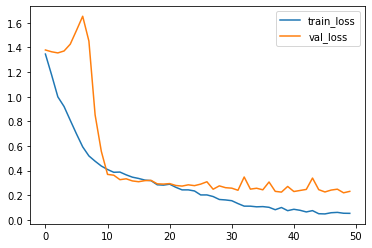

In [ ]:
plt.plot(trn_loss_list, label='train_loss')
plt.plot(val_loss_list, label='val_loss')
plt.legend()

In [ ]:
corrects = 0
total = 0

model.eval()
with torch.no_grad():
    for j, (data, target) in enumerate(dataloaders['test']):
        data, target = data.to(dev), target.to(dev)

        output = model(data)
        
        _, preds = torch.max(output, 1)
        corrects += torch.sum(preds == target.data)
        total += len(preds)

print("{}/{} | test accuracy: {:.4f}".format(corrects, total, corrects/total))

622/676 | test accuracy: 0.9201


In [ ]:
nb_classes = 4

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(dev)
        classes = classes.to(dev)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[151.,   0.,  19.,   0.],
        [  3., 190.,  13.,   1.],
        [ 14.,   3.,  60.,   1.],
        [  0.,   0.,   0., 221.]])


In [ ]:
#torch.save(model, '/content/gdrive/My Drive/krushimitra_be/tensor1.pt')

In [ ]:
#model = torch.load('/content/gdrive/My Drive/krushimitra_be/tensor1.pt')